In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from rich.progress import track
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
img_scale = 2

# import data and create trainloader
class Cropper:
    def __call__(self, img):
        return transforms.functional.crop(img, 35, 54, 218, 336)


# import data and create trainloader
train_dataset = datasets.ImageFolder(
    "data/train",
    transform=transforms.Compose(
        [
            transforms.Grayscale(),
            Cropper(),
            transforms.Resize((218 // img_scale, 336 // img_scale)),
            transforms.ToTensor(),
        ]
    ),
)
test_dataset = datasets.ImageFolder(
    "data/test",
    transform=transforms.Compose(
        [
            transforms.Grayscale(),
            Cropper(),
            transforms.Resize((218 // img_scale, 336 // img_scale)),
            transforms.ToTensor(),
        ]
    ),
)

train_data = torch.stack([train_dataset[i][0] for i in range(2,3)])
train_labels = torch.Tensor([train_dataset[i][1] for i in range(len(train_dataset))])

# plot transformed spectrograms
# plt.imshow(np.squeeze(train_data[0]))
# plt.show()
# exit()

test_data = torch.stack([test_dataset[i][0] for i in range(0,100)])
test_labels = torch.Tensor([test_dataset[i][1] for i in range(0,100)])


# construct CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.pool = nn.MaxPool2d(3, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 20, 5)
        self.conv3 = nn.Conv2d(20, 20, 3)
        self.conv4 = nn.Conv2d(20, 20, 3)
        self.fc1 = nn.Linear(41760, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn(self.conv1(x))))
        res1 = x.view(x.shape[0], -1).clone()
        x = self.pool(F.relu(self.bn(self.conv2(x))))
        res2 = x.view(x.shape[0], -1).clone()
        x = self.pool2(F.relu(self.bn(self.conv3(x))))
        res3 = x.view(x.shape[0], -1)
        x = F.relu(self.bn(self.conv4(x)))
        x = x.view(x.shape[0], -1)
        x = torch.cat((x, res1, res2, res3), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
model = ConvNet()
model.load_state_dict(torch.load('torch_model.pth'))
model.eval();

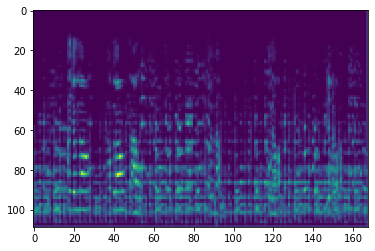

In [4]:
# select one image in training dataset
occ_img = test_data[0]
fig = plt.figure(facecolor="white")
plt.imshow(np.squeeze(test_data[0]))
plt.show()

In [5]:
rows = test_data.shape[2]
cols = test_data.shape[3]
print(rows, cols)

109 168


In [22]:
def gen_occlusions(image, kernel, stride, tr=False):
    # takes image (shape: (1, rows, cols))
    # returns stack of images (shape: (# of occlusions generated, 1, rows, cols))
    occluded = list()
    rows = image.shape[1]
    cols = image.shape[2]
    r = range(0, rows-kernel, stride)
    iterator = track(r) if tr else r
    for row in iterator:
        for col in range(0, cols-kernel, stride):
            occ_img = image.clone()
            occ_img[0, row:row+kernel, col:col+kernel] = 0
            occluded.append(occ_img)
    return torch.stack(occluded)

def comp_occlusions(image, kernel, stride, mod, tr=False):
    occlusions = gen_occlusions(image, kernel, stride, tr=tr)
    true_out = mod(torch.unsqueeze(image, 0))
    outputs = mod(occlusions)
    copied_out = true_out.repeat(outputs.shape[0], 1)
    
    diff = torch.linalg.norm(outputs - copied_out, dim=1)
    rows = image.shape[1]
    cols = image.shape[2]
    out_rows = ((rows-kernel-1) // stride) + 1
    out_cols = ((cols-kernel-1) // stride) + 1
    
    return diff.view(out_rows, out_cols).detach()

Output()

5 8 torch.Size([40])


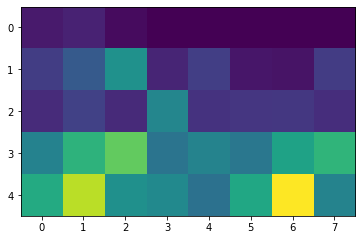

In [19]:
plt.imshow(comp_occlusions(test_data[0], 20, 20, model, tr=True))

torch.Size([1, 109, 168]) torch.Size([1, 5, 8])


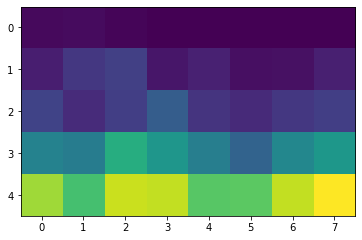

In [20]:
pool = nn.AvgPool2d(20, 20)
pooled = pool(test_data[0])
print(test_data[0].shape, pooled.shape)
plt.imshow(pooled.squeeze())

In [21]:
test_occlusions = [comp_occlusions(test_data[i], 20, 20, model) for i in range(len(test_data))]

5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Size([40])
5 8 torch.Siz

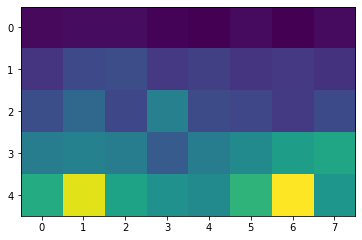

In [31]:
plt.imshow(torch.sum(torch.stack(test_occlusions), dim=0))

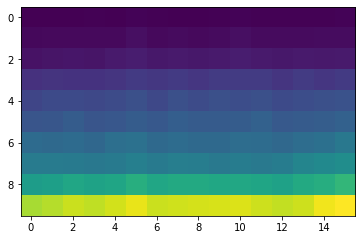

In [36]:
plt.imshow(torch.sum(nn.AvgPool2d(5, )(test_data), dim=0).squeeze())

In [ ]:
rows = test_data.shape[2]
cols = test_data.shape[3]
all_outputs = []
all_diffs = []
# calculate output for original image
original_output = model(test_data).detach().numpy()
sq = 1
# calculate outputs for occluded images
for row in track(range(rows)):
    for col in range(cols):
        try:
            occ_img = test_data.clone()
            occ_img[0][0][row][col] = 0
            tmp_out = model(occ_img)
            all_outputs.append(tmp_out.detach().numpy())
        except IndexError:
            print(f"IndexError at row {row} and column {col}.")

In [9]:
# now calculate differences
for output in all_outputs:
    all_diffs.append((np.linalg.norm(original_output-output)))

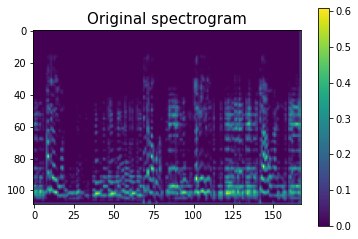

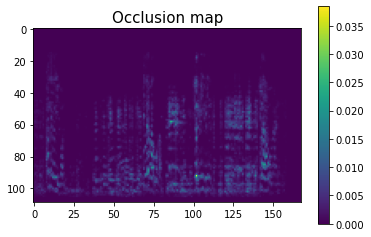

In [16]:
# now reshape and display masked spectrogram
all_diffs = np.array(all_diffs)
mask = all_diffs.reshape(-1, 168)

fig = plt.figure(facecolor="white")
plt.title("Original spectrogram", fontsize=15)
plt.imshow(np.squeeze(test_data.detach().numpy()))
plt.colorbar()
plt.show()

fig = plt.figure(facecolor="white")
plt.title("Occlusion map", fontsize=15)
plt.imshow(mask)
plt.colorbar()
plt.show()